In [1]:
import os
import re
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [2]:
%matplotlib inline

In [3]:
NAME_REGEX = r"((checkpoint|events|args).*)|report-dev-m(?P<d>[^-]*(start-with-beams)?(,,overfit=[a-z_]*)?)-(?P<s>[0-9]*)-(?P<t>train|eval|real)\.jsonl$"

In [4]:
def table_of_accuracies(label):
    logdirs =  glob.glob("../logdirs/{},*".format(label))
    if not logdirs:
        print("nothing found", label)
        1/0
    [logdir] = logdirs
    data = []
    for f in os.listdir(logdir):
        if not f.endswith(".jsonl"): continue
        m = re.match(NAME_REGEX, f)
        assert m, "{} not a valid name".format(f)
        if m.group("d") is None:
            print(m)
            1/0
            continue
        data_source = m.group("t")
        data_label = m.group("d")
        checkpoint = int(m.group("s"))
        datatype = m.group("t")
        with open(os.path.join(logdir, f)) as fp:
            try:
                stats = json.loads(next(fp))
            except StopIteration:
                stats = None
        if stats is None or not stats.get('done', stats['total'] >= 2500):
#             print(os.path.join(logdir, f))
#             print(stats)
            continue
        
        data.append([label, checkpoint, stats['correct'] / stats['total'], stats['total'], data_source, data_label])
    df = pd.DataFrame(
        data, columns=['Model', 'Step', 'Accuracy', 'Total', 'DataSource', 'DataLabel']
    )
    return df
def by_max_step(accuracies):
    max_step = accuracies.groupby(list(set(accuracies) - {'Step', 'Accuracy'})).transform(max).Step
    return accuracies[accuracies.Step == max_step]
def by_max_acc(accuracies):
    max_acc = accuracies.groupby(list(set(accuracies) - {'Step', 'Accuracy'})).transform(max).Accuracy
    possible_dup_max_acc = accuracies[accuracies.Accuracy == max_acc]
    # deduplicate
    return by_max_step(possible_dup_max_acc)


In [5]:
model_labels = """
vanilla
old-vanilla_d9e7601
vanilla-1
vanilla-2
vanilla-3
vanilla-123

aggregate-standard
aggregate-with-io
aggregate-with-io-123

vanilla-real-nearai-finetuned-1e-4
aggregate-with-io-real-nearai-finetuned-1e-4

# vanilla-real-nearai-finetuned-rl-1e-5
# aggregate-with-io-real-nearai-finetuned-rl-1e-5

# vanilla-many-mutations
# aggregate-with-io-many-mutations
# vanilla-real-nearai-finetuned-rl-1e-5-use-heldout
# aggregate-with-io-real-nearai-finetuned-rl-1e-5-use-heldout

# vanilla-real-nearai-finetuned-1e-5
# aggregate-with-io-real-nearai-finetuned-1e-5

vanilla-real-nearai32-finetuned-1e-4
aggregate-with-io-real-nearai32-finetuned-1e-4

vanilla-123-real-nearai-finetuned-1e-4
vanilla-123-real-nearai32-finetuned-1e-4

aggregate-with-io-123-real-nearai-finetuned-1e-4
aggregate-with-io-123-real-nearai32-finetuned-1e-4

vanilla-finetuned-agg
vanilla-finetuned-agg-start-with-finetuned
vanilla-finetuned-agg-start-with-finetuned-nearai32

vanilla-123-finetuned-agg-start-with-finetuned
vanilla-123-finetuned-agg-start-with-finetuned-nearai32
""".strip().split("\n")
model_labels = [x for x in model_labels if x and x[0] != '#']

In [6]:
accuracies = [table_of_accuracies(x) for x in model_labels]
accuracies = pd.concat(accuracies)

In [7]:
with open("../baseline/nearai-val.json") as f:
    nearai_results = json.load(f)
nearai_baseline_correct = sum(x['is_correct'] for x in nearai_results)
print(nearai_baseline_correct)
print(sum(x['passes_given_tests'] for x in nearai_results))

acs = accuracies[accuracies.DataLabel.map(lambda x: ('nearai,' in x or x == 'nearai') and ',,overfit=' not in x)].copy()
acs.Accuracy *= acs.Total
acs.Accuracy += nearai_baseline_correct
acs.Accuracy /= 2500
acs = pd.concat([acs, accuracies[accuracies.DataLabel.map(lambda x: 'nearai,' in x and ',,overfit=' in x)].copy()])
acs = acs[['Model', 'Step', 'DataLabel', 'Accuracy']].copy()
acs_nearai = acs

1525
1588


In [8]:
with open("../baseline/nearai32-val-just-first-beam.json") as f:
    nearai32_results = json.load(f)
nearai32_baseline_correct = sum(x['is_correct'] for x in nearai32_results)
print(nearai32_baseline_correct)
print(sum(x['passes_given_tests'] for x in nearai32_results))

acs = accuracies[accuracies.DataLabel.map(lambda x: x.startswith('nearai32') and ",,overfit=" not in x)].copy()
acs.Accuracy *= acs.Total
acs.Accuracy += nearai32_baseline_correct
acs.Accuracy /= 2500
acs = pd.concat([acs, accuracies[accuracies.DataLabel.map(lambda x: x.startswith('nearai32') and ",,overfit=" in x)].copy()])
acs = acs[['Model', 'Step', 'DataLabel', 'Accuracy']].copy()
acs_nearai32 = acs

1950
2056


In [9]:
def separate_strategies(df_orig):
    df_orig = by_max_acc(df_orig)
    df = []
    for data_source in "nearai", "nearai32":
        for model in model_labels:
            for s in "G", "B":
                for start_with_beams in True, False:
                    if (data_source == "nearai") == start_with_beams:
                        continue
                    for k in 1, 5, 10, 25, 50, 100:
                        if s == "G" and k == 1:
                            continue # exactly the same as B and 1
                        strategy = "{},,{},,{}".format(data_source, {"G" : "greedy", "B" : "best_first"}[s[0]], k) + ",,start-with-beams" * start_with_beams
                        filtered = df_orig[(df_orig.DataLabel == strategy) & (df_orig.Model == model)]
                        if len(filtered) == 0:
                            print(model, strategy)
                            continue
                        assert len(filtered) == 1
                        df.append([model, data_source, s, start_with_beams, k, 100 - 100 * filtered.iloc[0].Accuracy])
            filtered = df_orig[(df_orig.DataLabel == data_source) & (df_orig.Model == model)]
            if len(filtered) > 0:
                assert len(filtered) == 1
                df.append([model, data_source, "X", False, 1, 100 - 100 * filtered.iloc[0].Accuracy])
            else:
                print(model, data_source)
    return pd.DataFrame(df, columns=["model", "synthesizer", "strategy", "start with beams", "debugger steps", "error"])
def by_k(topline):
    columns_except_k = [col for col in topline if col != 'debugger steps' and col != 'error']
    result = {}
    k_vals = [1, 5, 10, 25, 50, 100]
    def set_value(key, k, accuracy):
        if key not in result:
            result[key] = list(key) + [''] * len(k_vals)
        loc = len(key) + k_vals.index(k)
        assert result[key][loc] == ''
        result[key][loc] = accuracy

    for _, row in topline.iterrows():
        k = row['debugger steps']
        set_value(tuple(row[c] for c in columns_except_k), k, row['error'])
        if k == 1 and row.strategy == 'B':
            set_value(tuple('G' if c == 'strategy' else row[c] for c in columns_except_k), k, row['error'])
    
    return pd.DataFrame(list(result.values()), columns=columns_except_k + k_vals)

In [10]:
topline = separate_strategies(pd.concat([acs_nearai32, acs_nearai]))
topline.to_csv("/home/kavigupta/topline.csv")

old-vanilla_d9e7601 nearai,,greedy,,25
old-vanilla_d9e7601 nearai,,greedy,,50
old-vanilla_d9e7601 nearai,,greedy,,100
old-vanilla_d9e7601 nearai,,best_first,,25
old-vanilla_d9e7601 nearai,,best_first,,50
old-vanilla_d9e7601 nearai,,best_first,,100
vanilla-2 nearai,,greedy,,100
vanilla-3 nearai,,greedy,,100
vanilla-123 nearai,,greedy,,50
vanilla-123 nearai,,greedy,,100
vanilla-123 nearai,,best_first,,50
vanilla-123 nearai,,best_first,,100
aggregate-with-io-123 nearai,,greedy,,50
aggregate-with-io-123 nearai,,greedy,,100
aggregate-with-io-123 nearai,,best_first,,50
aggregate-with-io-123 nearai,,best_first,,100
vanilla-real-nearai-finetuned-1e-4 nearai,,greedy,,50
vanilla-real-nearai-finetuned-1e-4 nearai,,greedy,,100
aggregate-with-io-real-nearai-finetuned-1e-4 nearai,,greedy,,50
aggregate-with-io-real-nearai-finetuned-1e-4 nearai,,greedy,,100
vanilla-real-nearai32-finetuned-1e-4 nearai,,greedy,,50
vanilla-real-nearai32-finetuned-1e-4 nearai,,greedy,,100
aggregate-with-io-real-nearai32-f

In [11]:
topline_by_k = by_k(topline)
topline_by_k.to_csv('/home/kavigupta/topline_by_k.csv')

In [12]:
just_max_step = by_max_step(accuracies)

In [13]:
def get_accuracies(model, data_source, data_label=None):
    selected_rows = (accuracies.Model == model) & (accuracies.DataSource == data_source)
    if data_label is not None:
        selected_rows &= accuracies.DataLabel == data_label
    return accuracies[selected_rows].pivot(index='Step', columns='DataLabel', values='Accuracy')
def plot_combined_accuracy(table, label):
    if not table.index.size:
        return
    cols = sorted(table.columns)
    print(cols)
    result = sum(table[col] for col in cols) * 100 / len(cols)
    plt.plot(result, ".-", label=label)
    plt.xlabel("Step")
    plt.ylabel("Accuracy [%]")
    plt.legend()

In [14]:
# # temporary for thesis draft
# plt.figure(figsize=(7, 5))
# plt.title("Val Results on Mutation Dataset")
# for model in "vanilla", "aggregate-standard", "aggregate-with-io":
#     plot_combined_accuracy(get_accuracies(model, 'eval'), model.replace('-', ' ').title())

# plt.xlim(5 * 10 ** 4, 10 ** 6)
# plt.ylabel("% of programs that pass all given test cases")
# plt.show()

In [15]:
# # temporary for thesis draft
# plt.figure(figsize=(7, 5))
# plt.title("Val Results on Mutation Dataset")
# for model in model_labels:
#     if "finetuned" in model and "1e-4" in model:
#         plot_combined_accuracy(get_accuracies(model, 'eval'), model.replace('-', ' ').title())

# plt.ylabel("% of programs that pass all given test cases")
# plt.show()
# plt.figure(figsize=(7, 5))
# plt.title("Val Results on Real Dataset")
# for model in model_labels:
#     if "finetuned" in model and "1e-4" in model:
#         plot_combined_accuracy(get_accuracies(model, 'real', 'nearai'), model.replace('-', ' ').title())

# plt.ylabel("% of programs that pass all given test cases")
# plt.show()

['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']
['nearai,,best_first,,10']


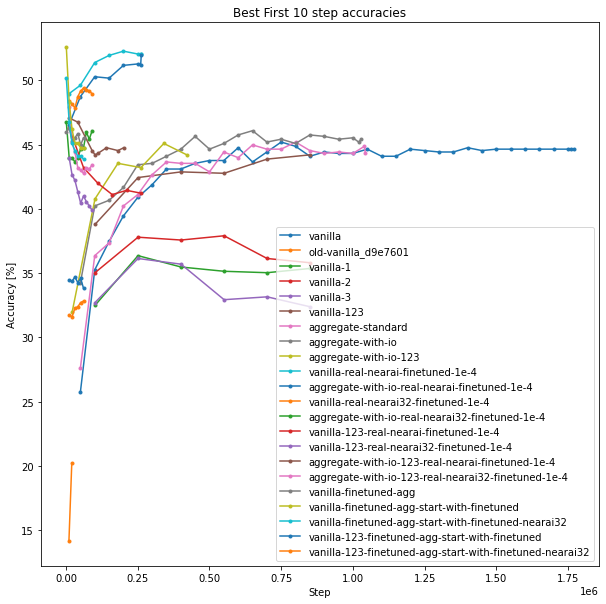

In [16]:
plt.figure(figsize=(10, 10))
plt.title("Best First 10 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,best_first,,10'), model)

['0,0,1', '0,1', '1']
['0,0,1', '0,1', '1']
['0,0,1', '0,1', '1']


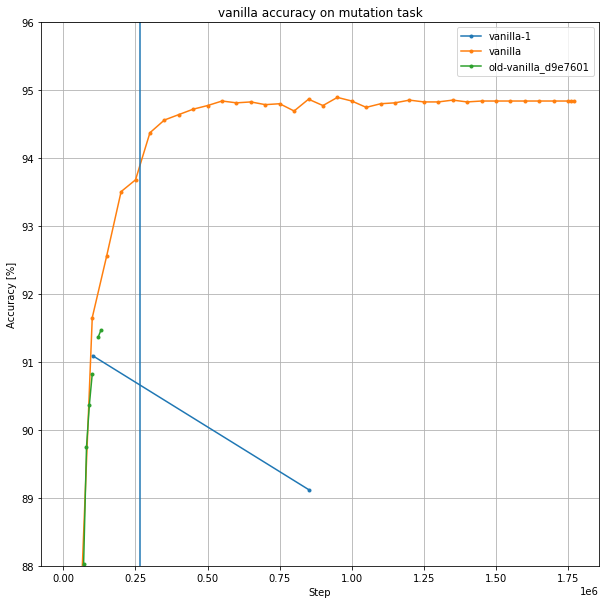

In [18]:
# plt.figure(figsize=(10, 10))
# plt.title("Best First 25 vanilla step accuracies on nearai32 (multiple starts)")
# for suffix in "-1", "-2", "-3", "":
#     model = "vanilla" + suffix
#     plot_combined_accuracy(get_accuracies(model, 'real', 'nearai32,,best_first,,25,,start-with-beams'), model)
# plt.show()
plt.figure(figsize=(10, 10))
plt.title("vanilla accuracy on mutation task")
for suffix in "-1", "":
    model = "vanilla" + suffix
    plot_combined_accuracy(get_accuracies(model, 'eval'), model)
model = "old-vanilla_d9e7601"
plot_combined_accuracy(get_accuracies(model, 'eval'), model)
plt.axvline(264200)
plt.ylim(88, 96)
plt.grid()